<a href="https://colab.research.google.com/github/gyyang/neurogym/blob/master/examples/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NeuroGym

NeuroGym is a comprehensive toolkit that allows training any network model on many established neuroscience tasks using Reinforcement Learning techniques. It includes working memory tasks, value-based decision tasks and context-dependent perceptual categorization tasks.

In this notebook we first show how to install the relevant toolbox. 

We then show how to access the available tasks and their relevant information.

Finally we train an LSTM network on the Random Dots Motion task using the A2C algorithm [Mnih et al. 2016](https://arxiv.org/abs/1602.01783) implemented in the [stable-baselines](https://github.com/hill-a/stable-baselines) toolbox, and plot the results.

You can easily change the code to train a network on any other available task or using a different algorithm (e.g. ACER, PPO2).


### Installation

In [1]:
%tensorflow_version 1.x
# Install gym
! pip install gym
# Install neurogym
! git clone https://github.com/gyyang/neurogym.git
%cd neurogym/
! pip install -e .
# Install stable-baselines
! pip install --upgrade stable-baselines

Cloning into 'neurogym'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 7033 (delta 138), reused 118 (delta 72), pack-reused 6838
Receiving objects: 100% (7033/7033), 5.92 MiB | 10.79 MiB/s, done.
Resolving deltas: 100% (5133/5133), done.
/content/neurogym
Obtaining file:///content/neurogym
  Running setup.py develop for neurogym
     |████████████████████████████████| 235kB 5.1MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


### Explore tasks

In [2]:
import warnings
import gym
import neurogym as ngym
from neurogym.utils import info, plotting
warnings.filterwarnings('ignore')
info.all_tasks()

AngleReproduction-v0
AntiReach-v0
Bandit-v0
CVLearning-v0
ChangingEnvironment-v0
ContextDecisionMaking-v0
DawTwoStep-v0
DelayPairedAssociation-v0
DelayedComparison-v0
DelayedMatchCategory-v0
DelayedMatchSample-v0
DelayedMatchToSampleDistractor1D-v0
Detection-v0
EconomicDecisionMaking-v0
GoNogo-v0
IntervalDiscrimination-v0
MatchingPenny-v0
MotorTiming-v0
NAltPerceptualDecisionMaking-v0
PerceptualDecisionMaking-v0
PerceptualDecisionMakingDelayResponse-v0
PostDecisionWager-v0
Reaching1D-v0
Reaching1DWithSelfDistraction-v0
ReachingDelayResponse-v0
ReadySetGo-v0


### Make a task

### PerceptualDecisionMaking
Doc: 
        Two-alternative forced choice task in which the subject has to
        integrate two stimuli to decide which one is higher on average.

        Parameters:
        dt: Timestep duration. (def: 100 (ms), int)
        rewards:
            R_ABORTED: given when breaking fixation. (def: -0.1, float)
            R_CORRECT: given when correct. (def: +1., float)
            R_FAIL: given when incorrect. (def: 0., float)
        timing: Description and duration of periods forming a trial.
        stimEv: Controls the difficulty of the experiment. (def: 1., float)
        
Reference paper: 
[The analysis of visual motion: a comparison of neuronal and psychophysical performance](https://www.jneurosci.org/content/12/12/4745)

Default Period timing (ms) 
fixation : constant 100
stimulus : constant 2000
decision : constant 100

Tags: perceptual, two-alternative, supervised.



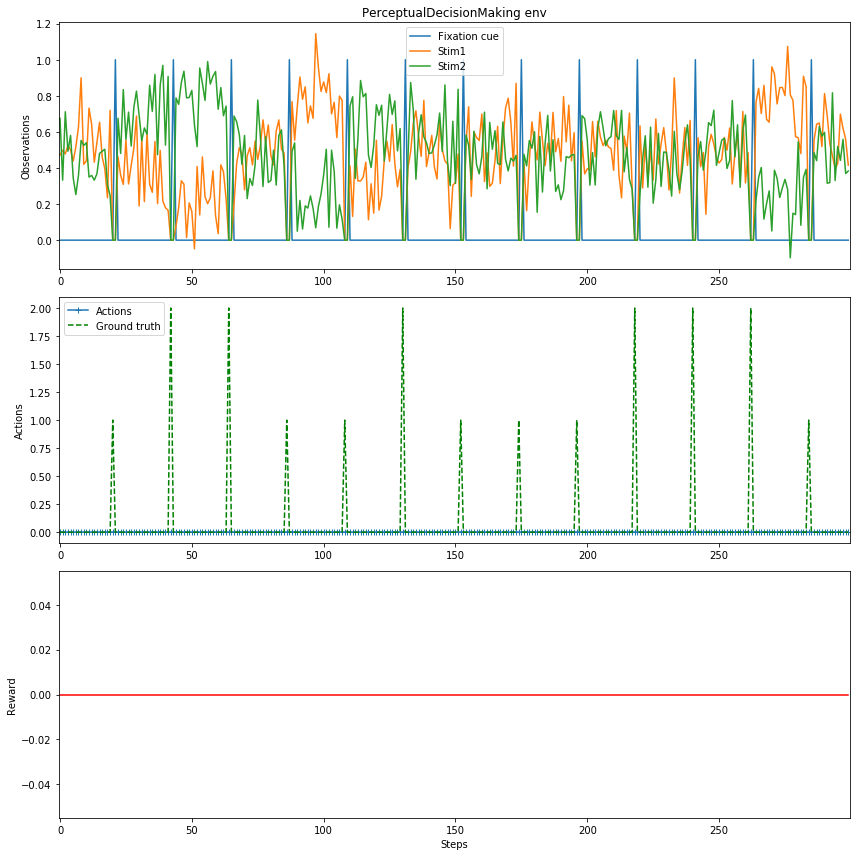

In [3]:

task = 'PerceptualDecisionMaking-v0'
env = gym.make(task);
print(env)
plotting.plot_env(env, num_steps_env=300, def_act=0, obs_traces=['Fixation cue', 'Stim1', 'Stim2'], fig_kwargs={'figsize': (12, 12)});

### Explore wrappers

In [4]:
info.all_wrappers()

CatchTrials-v0
Combine-v0
MissTrialReward-v0
Monitor-v0
Noise-v0
PassAction-v0
PassReward-v0
ReactionTime-v0
SideBias-v0
TTLPulse-v0
TrialHistory-v0


In [5]:
info.info_wrapper('TrialHistory-v0', show_code=True);

### TrialHistory-v0

Logic: Change ground truth probability based on previous outcome.

Reference paper: 

[Response outcomes gate the impact of expectations on perceptual decisions](https://www.biorxiv.org/content/10.1101/433409v3)


#### Source code #### 

class TrialHistory(ngym.TrialWrapper):
    metadata = {
        'description': 'Change ground truth probability ' +
        'based on previous outcome.',
        'paper_link': 'https://www.biorxiv.org/content/10.1101/433409v3',
        'paper_name': 'Response outcomes gate the impact of expectations ' +
        'on perceptual decisions'
    }

    def __init__(self, env, rep_prob=(.2, .8), block_dur=200,
                 blk_ch_prob=None):
        """
        Change ground truth probability based on previous outcome.
        rep_prob: Specifies probabilities of repeating for each block.
        (def: (.2, .8), tuple)
        block_dur: Number of trials per block. (def: 200 (int)
        blk_ch_prob: If not None, specifies the proba

### Train a network

In [0]:
import warnings
from neurogym.wrappers import trial_hist, monitor
from stable_baselines.common.policies import LstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C  # ACER, PPO2
warnings.filterwarnings('ignore')
warnings.filterwarnings('default')
# task paremters
task = 'PerceptualDecisionMaking-v0'
timing = {'fixation': ('constant', 300),
          'stimulus': ('constant', 700),
          'decision': ('constant', 300)}
kwargs = {'dt': 100, 'timing': timing, 'stimEv': 2}
# wrapper parameters
rep_prob = (.1, .9)
block_dur = 50

# build task
env = gym.make(task, **kwargs)
# Apply the wrapper
env = trial_hist.TrialHistory(env, rep_prob=rep_prob, block_dur=block_dur)
env = monitor.Monitor(env, folder='/content/tests/', sv_per=10000, verbose=1, sv_fig=True, num_stps_sv_fig=100)
# the env is now wrapped automatically when passing it to the constructor
env = DummyVecEnv([lambda: env])
model = A2C(LstmPolicy, env, verbose=1, policy_kwargs={'feature_extraction':"mlp"})
model.learn(total_timesteps=500000, log_interval=100000)
env.close()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------
| explained_variance | -0.18    |
| fps                | 19       |
| nupdates           | 1        |
| policy_entropy     | 1.1      |
| total_timesteps    | 5        |
| value_loss         | 0.0128   |
---------------------------------


# Visualize results

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


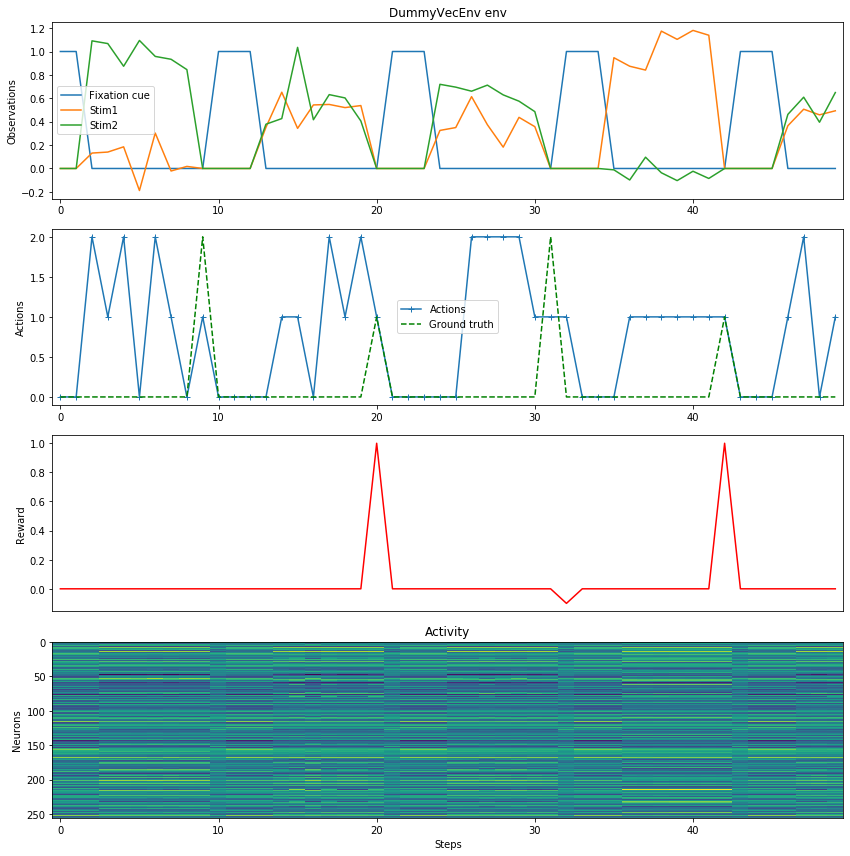

In [7]:
import numpy as np
import matplotlib.pyplot as plt
# Create task
env = gym.make(task, **kwargs)
# Apply the wrapper
env = trial_hist.TrialHistory(env, rep_prob=rep_prob, block_dur=block_dur)
env = DummyVecEnv([lambda: env])
plotting.plot_env(env, num_steps_env=50, def_act=0, obs_traces=['Fixation cue', 'Stim1', 'Stim2'], fig_kwargs={'figsize': (12, 12)}, model=model);

In [8]:
step_by_step_data = plotting.plot_env(env, num_steps_env=5000, def_act=0, obs_traces=['Fixation cue', 'Stim1', 'Stim2'], fig_kwargs={'figsize': (12, 12)}, model=model, show_fig=False);
list(step_by_step_data)

['obs',
 'obs_cum',
 'rewards',
 'actions',
 'perf',
 'actions_end_of_trial',
 'gt',
 'states']

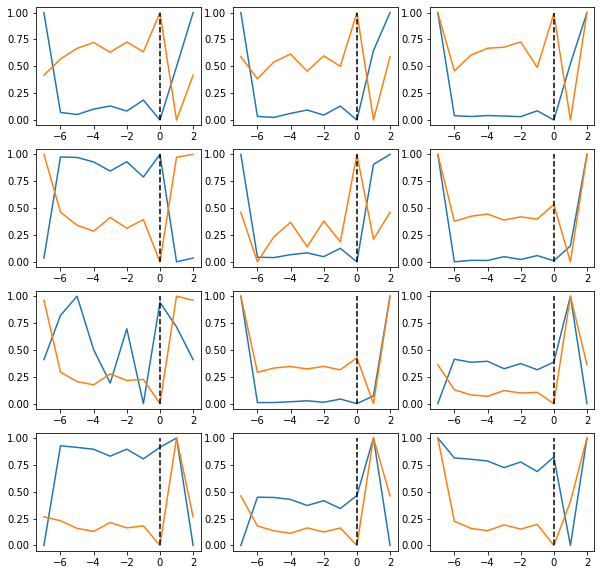

In [9]:
actions_end_of_trial = step_by_step_data['actions_end_of_trial']
actions_end_of_trial = np.array(actions_end_of_trial)
end_of_trial = np.where(actions_end_of_trial != -1)[0]
states = step_by_step_data['states']
states = states[:, int(states.shape[1]/2):]
baseline = 7
resp_window = 3
steps = np.arange(baseline+resp_window) - baseline
end_of_trial = end_of_trial[end_of_trial > baseline]
end_of_trial = end_of_trial[end_of_trial < states.shape[0]-resp_window]
mat_1 = np.zeros((baseline+resp_window, states.shape[1]))
mat_2 = np.zeros((baseline+resp_window, states.shape[1]))
for eot in end_of_trial:
  if actions_end_of_trial[eot] == 1:
    mat_1 += states[eot-baseline:eot+resp_window, :]
  elif actions_end_of_trial[eot] == 2:
    mat_2 += states[eot-baseline:eot+resp_window, :]
  elif actions_end_of_trial[eot] == -1:
    print('INVALID ACTION')

mat_1 -= np.min(mat_1, axis=0)
mat_1 = mat_1/np.mean(mat_1, axis=0)

mat_2 -= np.min(mat_2, axis=0)
mat_2 = mat_2/np.mean(mat_2, axis=0)

diff = np.sum(np.abs(mat_1 - mat_2), axis=0)
arr1inds = diff.argsort()
sorted_mat_1 = mat_1[:, arr1inds[::-1]]
sorted_mat_2 = mat_2[:, arr1inds[::-1]]
rows = 4
cols = 3
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10))
ax = ax.flatten()
for ind_ax in range(rows*cols):
  trace_1 = sorted_mat_1[:, ind_ax]
  trace_1 -= np.min(trace_1)
  trace_1 /= np.max(trace_1)
  ax[ind_ax].plot(steps, trace_1);
  trace_2 = sorted_mat_2[:, ind_ax]
  trace_2 -= np.min(trace_2)
  trace_2 /= np.max(trace_2)
  ax[ind_ax].plot(steps, trace_2);
  ax[ind_ax].plot([0, 0], [0, 1], '--k');


In [10]:
cd /content/tests/


/content/tests


In [11]:
ls

TrialHistory_bhvr_data__10000.npz
TrialHistory_bhvr_data__20000.npz
TrialHistory_bhvr_data__30000.npz
TrialHistory_bhvr_data__40000.npz
TrialHistory_bhvr_data__task_000008.png
TrialHistory_bhvr_data__task_010009.png
TrialHistory_bhvr_data__task_020009.png
TrialHistory_bhvr_data__task_030009.png
TrialHistory_bhvr_data__task_040009.png


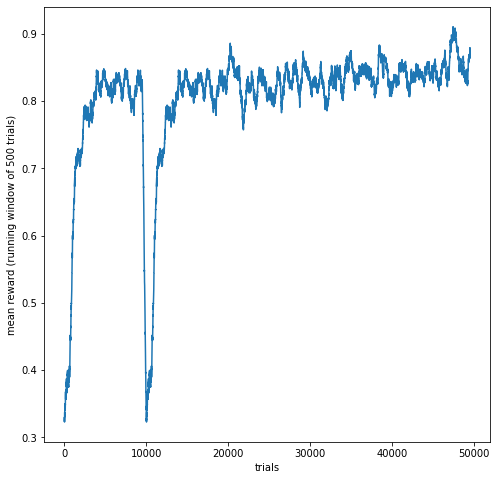

In [12]:
from neurogym.utils import plotting
plotting.plot_rew_across_training('/content/tests/')